# Lead Scoring Case Study

### Import Important libraries

In [3]:
# Import Important Libraries
import numpy as np
import pandas as pd

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Ignore future warnings
warnings.simplefilter('ignore', FutureWarning)

pd.set_option("display.max_rows", 500)
pd.set_option('display.max_colwidth', 1500)
pd.set_option('display.max_columns', None)

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data modelling
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Libraries for statsmodel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Libraries for sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve

# Libraries for PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

#### Read Leads data into dataframe

In [6]:
# Read into dataframe
leads = pd.read_csv("Leads.csv")
leads.head(10)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified
5,2058ef08-2858-443e-a01f-a9237db2f5ce,660680,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,01.High,02.Medium,17.0,15.0,No,No,Modified
6,9fae7df4-169d-489b-afe4-0f3d752542ed,660673,Landing Page Submission,Google,No,No,1,2.0,1640,2.0,Email Opened,India,Supply Chain Management,Online Search,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Low in Relevance,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,No,Modified
7,20ef72a2-fb3b-45e0-924e-551c5fa59095,660664,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
8,cfa0128c-a0da-4656-9d47-0aa4e67bf690,660624,Landing Page Submission,Direct Traffic,No,No,0,2.0,71,2.0,Email Opened,India,IT Projects Management,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Thane & Outskirts,02.Medium,02.Medium,14.0,14.0,No,Yes,Email Opened
9,af465dfc-7204-4130-9e05-33231863c4b5,660616,API,Google,No,No,0,4.0,58,4.0,Email Opened,India,Finance Management,Word Of Mouth,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Mumbai,02.Medium,02.Medium,13.0,16.0,No,No,Email Opened


In [7]:
# Copy orig leads for final interpretation
leads_orig = leads.copy()

#### Quick review of dataframe

In [8]:
# Review dataframe info
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

#### Shape of Leads dataframe

In [9]:
# Check shape of dataframe
leads.shape

(9240, 37)

#### Check for conversion rate in dataframe

In [10]:
# Conversion rate

round(leads["Converted"].sum()/len(leads.index),2)

0.39

Conversion rate is 39 percent

### Analyze data and prepare data

#### Check for missing values

In [11]:
# Check for missing value
round(100*(leads.isnull().sum()/len(leads.index)),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [12]:
# list all numeric and non-numeric columns
nonnumcols = list(leads.select_dtypes(include="object"))
numcols = list(leads.select_dtypes(exclude="object"))
len(nonnumcols),len(numcols)

(30, 7)

#### Check level of categorical columns

In [13]:
# Count for all categorical columns
for col in nonnumcols:
    print("="*50)
    print(col)
    print(leads[col].nunique())

Prospect ID
9240
Lead Origin
5
Lead Source
21
Do Not Email
2
Do Not Call
2
Last Activity
17
Country
38
Specialization
19
How did you hear about X Education
10
What is your current occupation
6
What matters most to you in choosing a course
3
Search
2
Magazine
1
Newspaper Article
2
X Education Forums
2
Newspaper
2
Digital Advertisement
2
Through Recommendations
2
Receive More Updates About Our Courses
1
Tags
26
Lead Quality
5
Update me on Supply Chain Content
1
Get updates on DM Content
1
Lead Profile
6
City
7
Asymmetrique Activity Index
3
Asymmetrique Profile Index
3
I agree to pay the amount through cheque
1
A free copy of Mastering The Interview
2
Last Notable Activity
16


In [14]:
# Count values
for col in nonnumcols:
    if(col=="Prospect ID"):
        pass
    else:
        print("="*50)
        print(col)
        print(leads[col].value_counts())

Lead Origin
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64
Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64
Do Not Email
No     8506
Yes     734
Name: Do Not Email, dtype: int64
Do Not Call
No     9238
Yes       2
Name: Do Not Call, dtype: int64
Last Activity
Email Opened                    3437
SMS Sent         

#### Lead Source has Google and google. Change it to Google

In [15]:
# Change google to Google
leads.loc[leads["Lead Source"]=="google","Lead Source"] = "Google"

#### Identify columns that have default "Select" value

In [16]:
# Columns which have "Select" as value

select_list = []
for col in nonnumcols:
    if(col=="Prospect ID"):
        pass
    else:
        if("Select" in leads[col].unique()):
            select_list.append(col) 
            
print(select_list)

['Specialization', 'How did you hear about X Education', 'Lead Profile', 'City']


#### Impute "Select" with "NA"

In [17]:
# Change all "Select" value to NA
for col in select_list:
    leads.loc[leads[col] == "Select",col]="NA"

In [18]:
# Check if all "Select" have been converted to "NA"
select_list2 = []
for col in nonnumcols:
    if(col=="Prospect ID"):
        pass
    else:
        if("Select" in leads[col].unique()):
            select_list2.append(col) 
            
print(select_list2)

[]


#### Identify categorical columns with missing values

In [19]:
# List all categorical columns with missing values
cat_nulls=[]
for col in nonnumcols:
    if(leads[col].isnull().values.any()):
        cat_nulls.append(col)

print(cat_nulls)

['Lead Source', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index']


In [20]:
# Impute Missing values for categorical variable with "NA"
for col in cat_nulls:
    leads.loc[pd.isnull(leads[col]),col]="NA"

#### Identify quantitative columns with missing values

In [21]:
# List all quantitative columns with missing values
quant_nulls=[]
for col in numcols:
    if(leads[col].isnull().values.any()):
        quant_nulls.append(col)

print(quant_nulls)

['TotalVisits', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']


In [22]:
# Checking statistics for col which has missing values
leads[quant_nulls].describe()

,TotalVisits,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9103.000000,9103.000000,5022.000000,5022.000000
mean,3.445238,2.362820,14.306252,16.344883
std,4.854853,2.161418,1.386694,1.811395
min,0.000000,0.000000,7.000000,11.000000
25%,1.000000,1.000000,14.000000,15.000000
50%,3.000000,2.000000,14.000000,16.000000
75%,5.000000,3.000000,15.000000,18.000000
max,251.000000,55.000000,18.000000,20.000000


#### Calculate percentage missing values (Re-check)

In [23]:
# Percentage missing values
round(100*(leads[quant_nulls].isnull().sum()/len(leads.index)),2)

TotalVisits                     1.48
Page Views Per Visit            1.48
Asymmetrique Activity Score    45.65
Asymmetrique Profile Score     45.65
dtype: float64

#### Observation - 
1. Removing rows with missing col information will lead to loss of data
2. We will impute missing values with median since there isn't significant difference between mean and median

#### Checking distribution of these quantitative variables

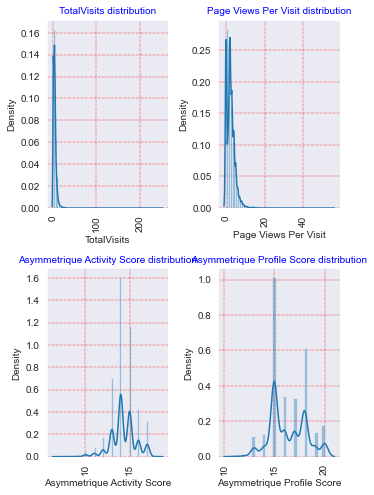

In [24]:
# Impute all missing quantitative columns with median values
    
# Plot for outliers
# Analyze outliers for quantitative variables

# calculation for subplots
ln = len(quant_nulls)
n=2
m=(ln//n)+1
ct=1


# Setting figure size
plt.figure(2,figsize=(5,10))

for cat in quant_nulls:
    sns.set_style("dark")
    plt.subplot(m,n,ct)
    plt.grid(color='r', linestyle='-.', linewidth=0.4)
    sns.distplot(leads.loc[pd.isnull(leads[cat])==False,cat])
    title = cat + " distribution"
    plt.title(title,color="b",fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10,rotation=90)
    ct+=1
    
# plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Impute quantitative columns

In [25]:
# Impute all missing quantitative columns with median values
for col in quant_nulls:
    col_median = leads[col].median()
    leads.loc[pd.isnull(leads[col]),col]=col_median

In [26]:
# Percentage missing values
round(100*(leads.isnull().sum()/len(leads.index)),2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
How did you hear about X Education               0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                             

In [27]:
# Calculating % of NAs in categorical column
for col in nonnumcols:
    if(col=="Prospect ID"):
        pass
    else:
        print(col, round(100*(len(leads[leads[col]=="NA"])/len(leads.index)),2))
        print("="*50)

Lead Origin 0.0
Lead Source 0.39
Do Not Email 0.0
Do Not Call 0.0
Last Activity 1.11
Country 26.63
Specialization 36.58
How did you hear about X Education 78.46
What is your current occupation 29.11
What matters most to you in choosing a course 29.32
Search 0.0
Magazine 0.0
Newspaper Article 0.0
X Education Forums 0.0
Newspaper 0.0
Digital Advertisement 0.0
Through Recommendations 0.0
Receive More Updates About Our Courses 0.0
Tags 36.29
Lead Quality 51.59
Update me on Supply Chain Content 0.0
Get updates on DM Content 0.0
Lead Profile 74.19
City 39.71
Asymmetrique Activity Index 45.65
Asymmetrique Profile Index 45.65
I agree to pay the amount through cheque 0.0
A free copy of Mastering The Interview 0.0
Last Notable Activity 0.0


#### Observation <br>
1. % of missing value (NA) is very high. We will drop these columns since they do not add much information
    * How did you hear about X Education
    * Lead Profile
    
2. % of missing value (NA) is very low. We will impute value with mode
    * Lead Source
    * Last Activity

#### Drop columns which has more than 70% missing values

In [28]:
# Drop columns with high missing values
leads.drop(["How did you hear about X Education","Lead Profile"],axis=1,inplace=True)

#### Impute missing values for categorical values with less missing values

In [29]:
# Impute missing values for categorical values
leads.loc[leads["Lead Source"]=="NA","Lead Source"] = leads[leads["Lead Source"]!="NA"]["Lead Source"].mode()[0]
leads.loc[leads["Last Activity"]=="NA","Last Activity"] = leads[leads["Last Activity"]!="NA"]["Lead Source"].mode()[0]

#### Update numcols and nonnumcols since we dropped few columns

In [30]:
# list all numerics and non-numeric columns
nonnumcols = list(leads.select_dtypes(include="object"))
numcols = list(leads.select_dtypes(exclude="object"))
len(nonnumcols),len(numcols)

(28, 7)

In [31]:
# Check outliers
leads[numcols].describe(percentiles=[.05,.25, .5, .75, .90, .95, .99])

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000
mean,617188.435606,0.385390,3.438636,487.698268,2.357440,14.166450,16.187446
std,23405.995698,0.486714,4.819024,548.021466,2.145781,1.033585,1.346358
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
5%,582869.900000,0.000000,0.000000,0.000000,0.000000,13.000000,15.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,16.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,14.000000,16.000000
90%,650506.100000,1.000000,7.000000,1380.000000,5.000000,15.000000,18.000000
95%,655404.050000,1.000000,10.000000,1562.000000,6.000000,16.000000,19.000000


#### Boxplot for quantitative varibles

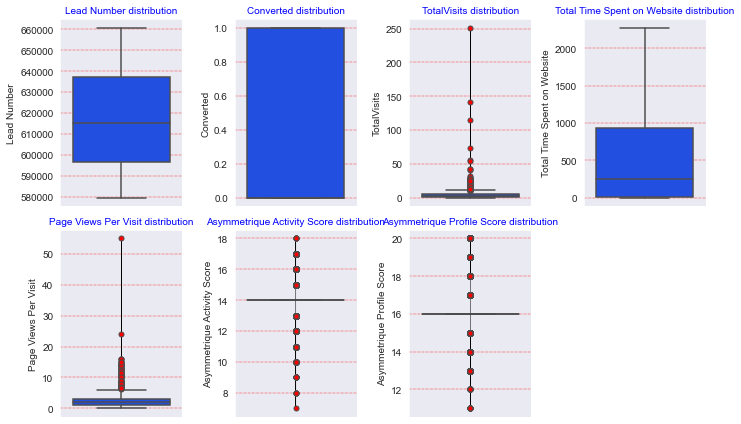

In [32]:
# Plot for outliers
# Analyze outliers for quantitative variables

# calculation for subplots
ln = len(numcols)
n=4
m=(ln//n)+1
ct=1


# Setting figure size
plt.figure(2,figsize=(10,6))

for cat in numcols:
    sns.set_style("dark")
    plt.subplot(m,n,ct)
    plt.grid(color='r', linestyle='-.', linewidth=0.4)
    flierprops = dict(marker='o',markerfacecolor='red', markersize=5,linewidth=0.5,
                linestyle='-')
    
    sns.boxplot(y=leads[cat],palette="bright",flierprops=flierprops)
    title = cat + " distribution"
    plt.title(title,color="b",fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10,rotation=90)
    ct+=1
    
plt.tight_layout()
plt.show()

In [33]:
leads["Total Time Spent on Website"].describe(percentiles=[.25, .5, .75, .95, .99])

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
25%        12.000000
50%       248.000000
75%       936.000000
95%      1562.000000
99%      1840.610000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

#### New derived column "Total Time Level"

In [34]:
#### New column

#### Defiane Votes level
def timemap(n):
    if(n>1840):
        return 6
    elif(n>1562):
        return 5
    elif(n>936):
        return 4
    elif(n>248):
        return 3
    elif(n>12):
        return 2
    else:
        return 1

# Create new column for votes level
leads["Total Time Level"] = leads["Total Time Spent on Website"].apply(timemap)

#### Bivariate Analysis

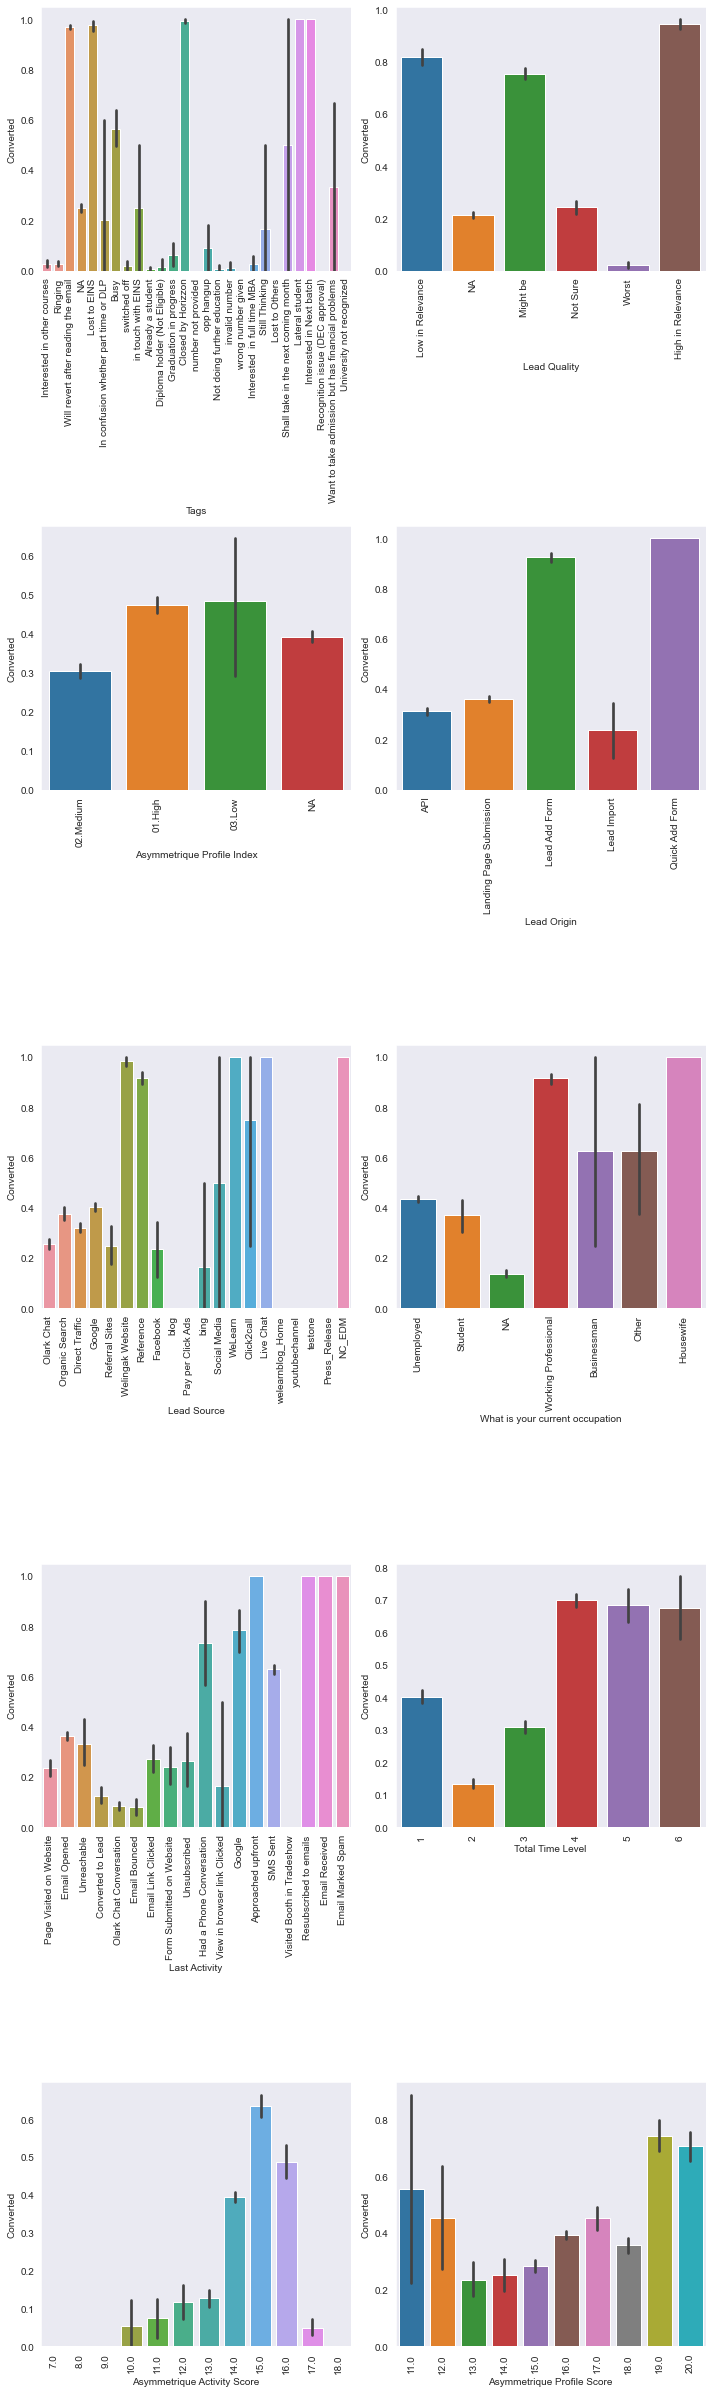

In [35]:
# Countplot for these categorical variables - application_clean
# Lead Origin, What is your current occupation and Last Activity

cols2anz = ["Tags","Lead Quality","Asymmetrique Profile Index","Lead Origin","Lead Source", 
            "What is your current occupation","Last Activity", 'Total Time Level',
            'Asymmetrique Activity Score','Asymmetrique Profile Score']

# Number of numerical columns
ln=len(cols2anz)

# calculation for subplots
n=2
m=(ln//n)+1
ct=1

# Setting figure size
plt.figure(2,figsize=(10,40))

# Running in loop to plot all columns as subplot
for column in cols2anz:
    plt.subplot(m,n,ct)

    plt.xticks(rotation=90)
    sns.barplot(x=column,y="Converted",data=leads)
    ct+=1

# plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Observation <br>
1. Tags (Will revert after reading the email) are good indicators to determine if lead will convert.
2. Lead Quality ('Might be' and 'High in Relevance') are good inficators to determine if lead will convert. 
3. Asymmetrique Profile Index of High is good indicator if lead will convert.
4. Lead Origin (Lead Add Form) is good indicator if lead will convert.
5. Lead Source ('Welingak Website' and 'Reference') are good indicators to determine if lead will convert.

### Outlier Analysis

In [36]:
# Create a temporary copy of leads
leads_temp = leads.copy()

In [37]:
# Checking shapes on dataframe
leads.shape, leads_temp.shape

((9240, 36), (9240, 36))

In [38]:
# Remove outliers
# Display and review data over and below cutoff

# Calculate Inter Quantile Region (75th Percentile - 25th Percentile)
# Upper cutoff = 75th percentile + 1.5 * (IQR)
# Lower cutoff = 25th percentile - 1.5 * (IQR)


print("Shape before outlier removal: ", leads_temp.shape)

before_row = leads_temp.shape[0]
 
def removeoutlier(leads_temp,col):
    
    print("="*50)
    print(col)
    col_q1,col_q3,_col_IQR,lower_cutoff,upper_cutoff = 0,0,0,0,0
    data=pd.DataFrame()
    outlier_data=pd.DataFrame()
    data=leads_temp[col]
    

    col_q1 = data.quantile(q=.25)
    col_q3 = data.quantile(q=.75)
    col_IQR = col_q3 - col_q1
    lower_cutoff = col_q1 - (1.5 * col_IQR)
    upper_cutoff = col_q3 + (1.5 * col_IQR)
    
    mask1 = (leads_temp[col] > lower_cutoff) & (leads_temp[col] < upper_cutoff)

    if(lower_cutoff==0) | (upper_cutoff==0) | (lower_cutoff == upper_cutoff):
        print("Check cutoff values, it's 0 for: ",col)
        return leads_temp
        pass
    else:
        leads_temp = leads_temp[mask1]
        return leads_temp

for column in numcols:
    if(column =="Lead Number"):
        pass
    else:
        leads_temp = removeoutlier(leads_temp,column)

after_row = leads_temp.shape[0]
print("Shape after outlier removal: ", leads_temp.shape)

Shape before outlier removal:  (9240, 36)
Converted
TotalVisits
Total Time Spent on Website
Page Views Per Visit
Asymmetrique Activity Score
Check cutoff values, it's 0 for:  Asymmetrique Activity Score
Asymmetrique Profile Score
Check cutoff values, it's 0 for:  Asymmetrique Profile Score
Shape after outlier removal:  (8381, 36)


In [39]:
# Shape after outlier removal:  (8381, 37)
# Data loss

data_loss = before_row - after_row
print("Rows lost: ",data_loss)
per = (data_loss/before_row)*100
print("Percentage of data loss: ",round(per,2))

Rows lost:  859
Percentage of data loss:  9.3


#### We will loose significant 9% of data if we remove outliers. We will keep these are scale the data. This will also help us in assigning score for all leads. Aim is to ensure metrics is good.

#### Create dummy variables

In [40]:
# Create dummy variable for relevant columns
cols4dummy = [ 'Lead Origin','Lead Source','Last Activity',
 'Specialization','What is your current occupation','City']

leads = pd.get_dummies(leads,columns=cols4dummy, drop_first = True)
leads.head(2)

,Prospect ID,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Total Time Level,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Google,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_NA,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_NA,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,No,No,0,0.0,0,0.0,NA,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,02.Medium,02.Medium,15.0,15.0,No,No,Modified,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,No,No,0,5.0,674,2.5,India,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NA,No,No,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


#### Encode Binary categorical columns

In [41]:
# Encode the categorical columns (Yes/No)
bincols=['A free copy of Mastering The Interview','I agree to pay the amount through cheque',
'Get updates on DM Content','Update me on Supply Chain Content',
'Receive More Updates About Our Courses','Through Recommendations',
'Digital Advertisement','Newspaper',
'X Education Forums','Newspaper Article',
'Magazine','Search','Do Not Call','Do Not Email']

def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

leads[bincols] = leads[bincols].apply(binary_map)
leads.head(2)

,Prospect ID,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Total Time Level,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Google,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_NA,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_NA,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,0,0,0,0.0,0,0.0,NA,Better Career Prospects,0,0,0,0,0,0,0,0,Interested in other courses,Low in Relevance,0,0,02.Medium,02.Medium,15.0,15.0,0,0,Modified,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,0,0,0,5.0,674,2.5,India,Better Career Prospects,0,0,0,0,0,0,0,0,Ringing,NA,0,0,02.Medium,02.Medium,15.0,15.0,0,0,Email Opened,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


#### Label encoding for other categorical columns

In [42]:
# Encode the categorical columns

cols2encode = [ 'Country','What matters most to you in choosing a course','Tags',
 'Lead Quality','Asymmetrique Activity Index',
 'Asymmetrique Profile Index','Last Notable Activity']

for col in cols2encode:
    if(col =="Prospect ID"):
        pass
    else:
        encode = LabelEncoder()
        leads[col] = encode.fit_transform(leads[col])
    
leads.head()

,Prospect ID,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Total Time Level,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Google,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_NA,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_NA,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_NA,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,0,0,0,0.0,0,0.0,19,0,0,0,0,0,0,0,0,0,8,1,0,0,1,1,15.0,15.0,0,0,8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,0,0,0,5.0,674,2.5,12,0,0,0,0,0,0,0,0,0,15,3,0,0,1,1,15.0,15.0,0,0,4,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,0,0,1,2.0,1532,2.0,12,0,0,0,0,0,0,0,0,0,20,2,0,0,1,0,14.0,20.0,0,1,4,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,0,0,0,1.0,305,1.0,12,0,0,0,0,0,0,0,0,0,15,4,0,0,1,0,13.0,17.0,0,0,8,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,660681,0,0,1,2.0,1428,1.0,12,0,0,0,0,0,0,0,0,0,20,2,0,0,1,0,15.0,18.0,0,0,8,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

#### Drop columns with no variance

In [43]:
# List of columns with one 1 value
leadscol = leads.columns
col2rmv = []

for col in leadscol:
    if(leads[col].nunique()==1):
        col2rmv.append(col)
        
print(col2rmv)

['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque']


In [44]:
# Drop columns which have only 1 value
print(leads.shape)
leads.drop(col2rmv,axis=1,inplace=True)
print(leads.shape)

(9240, 100)
(9240, 95)


In [45]:
# Checking the Converted Rate
convert = (sum(leads['Converted'])/len(leads['Converted'].index))*100
round(convert,2)

38.54

#### Checking correlation

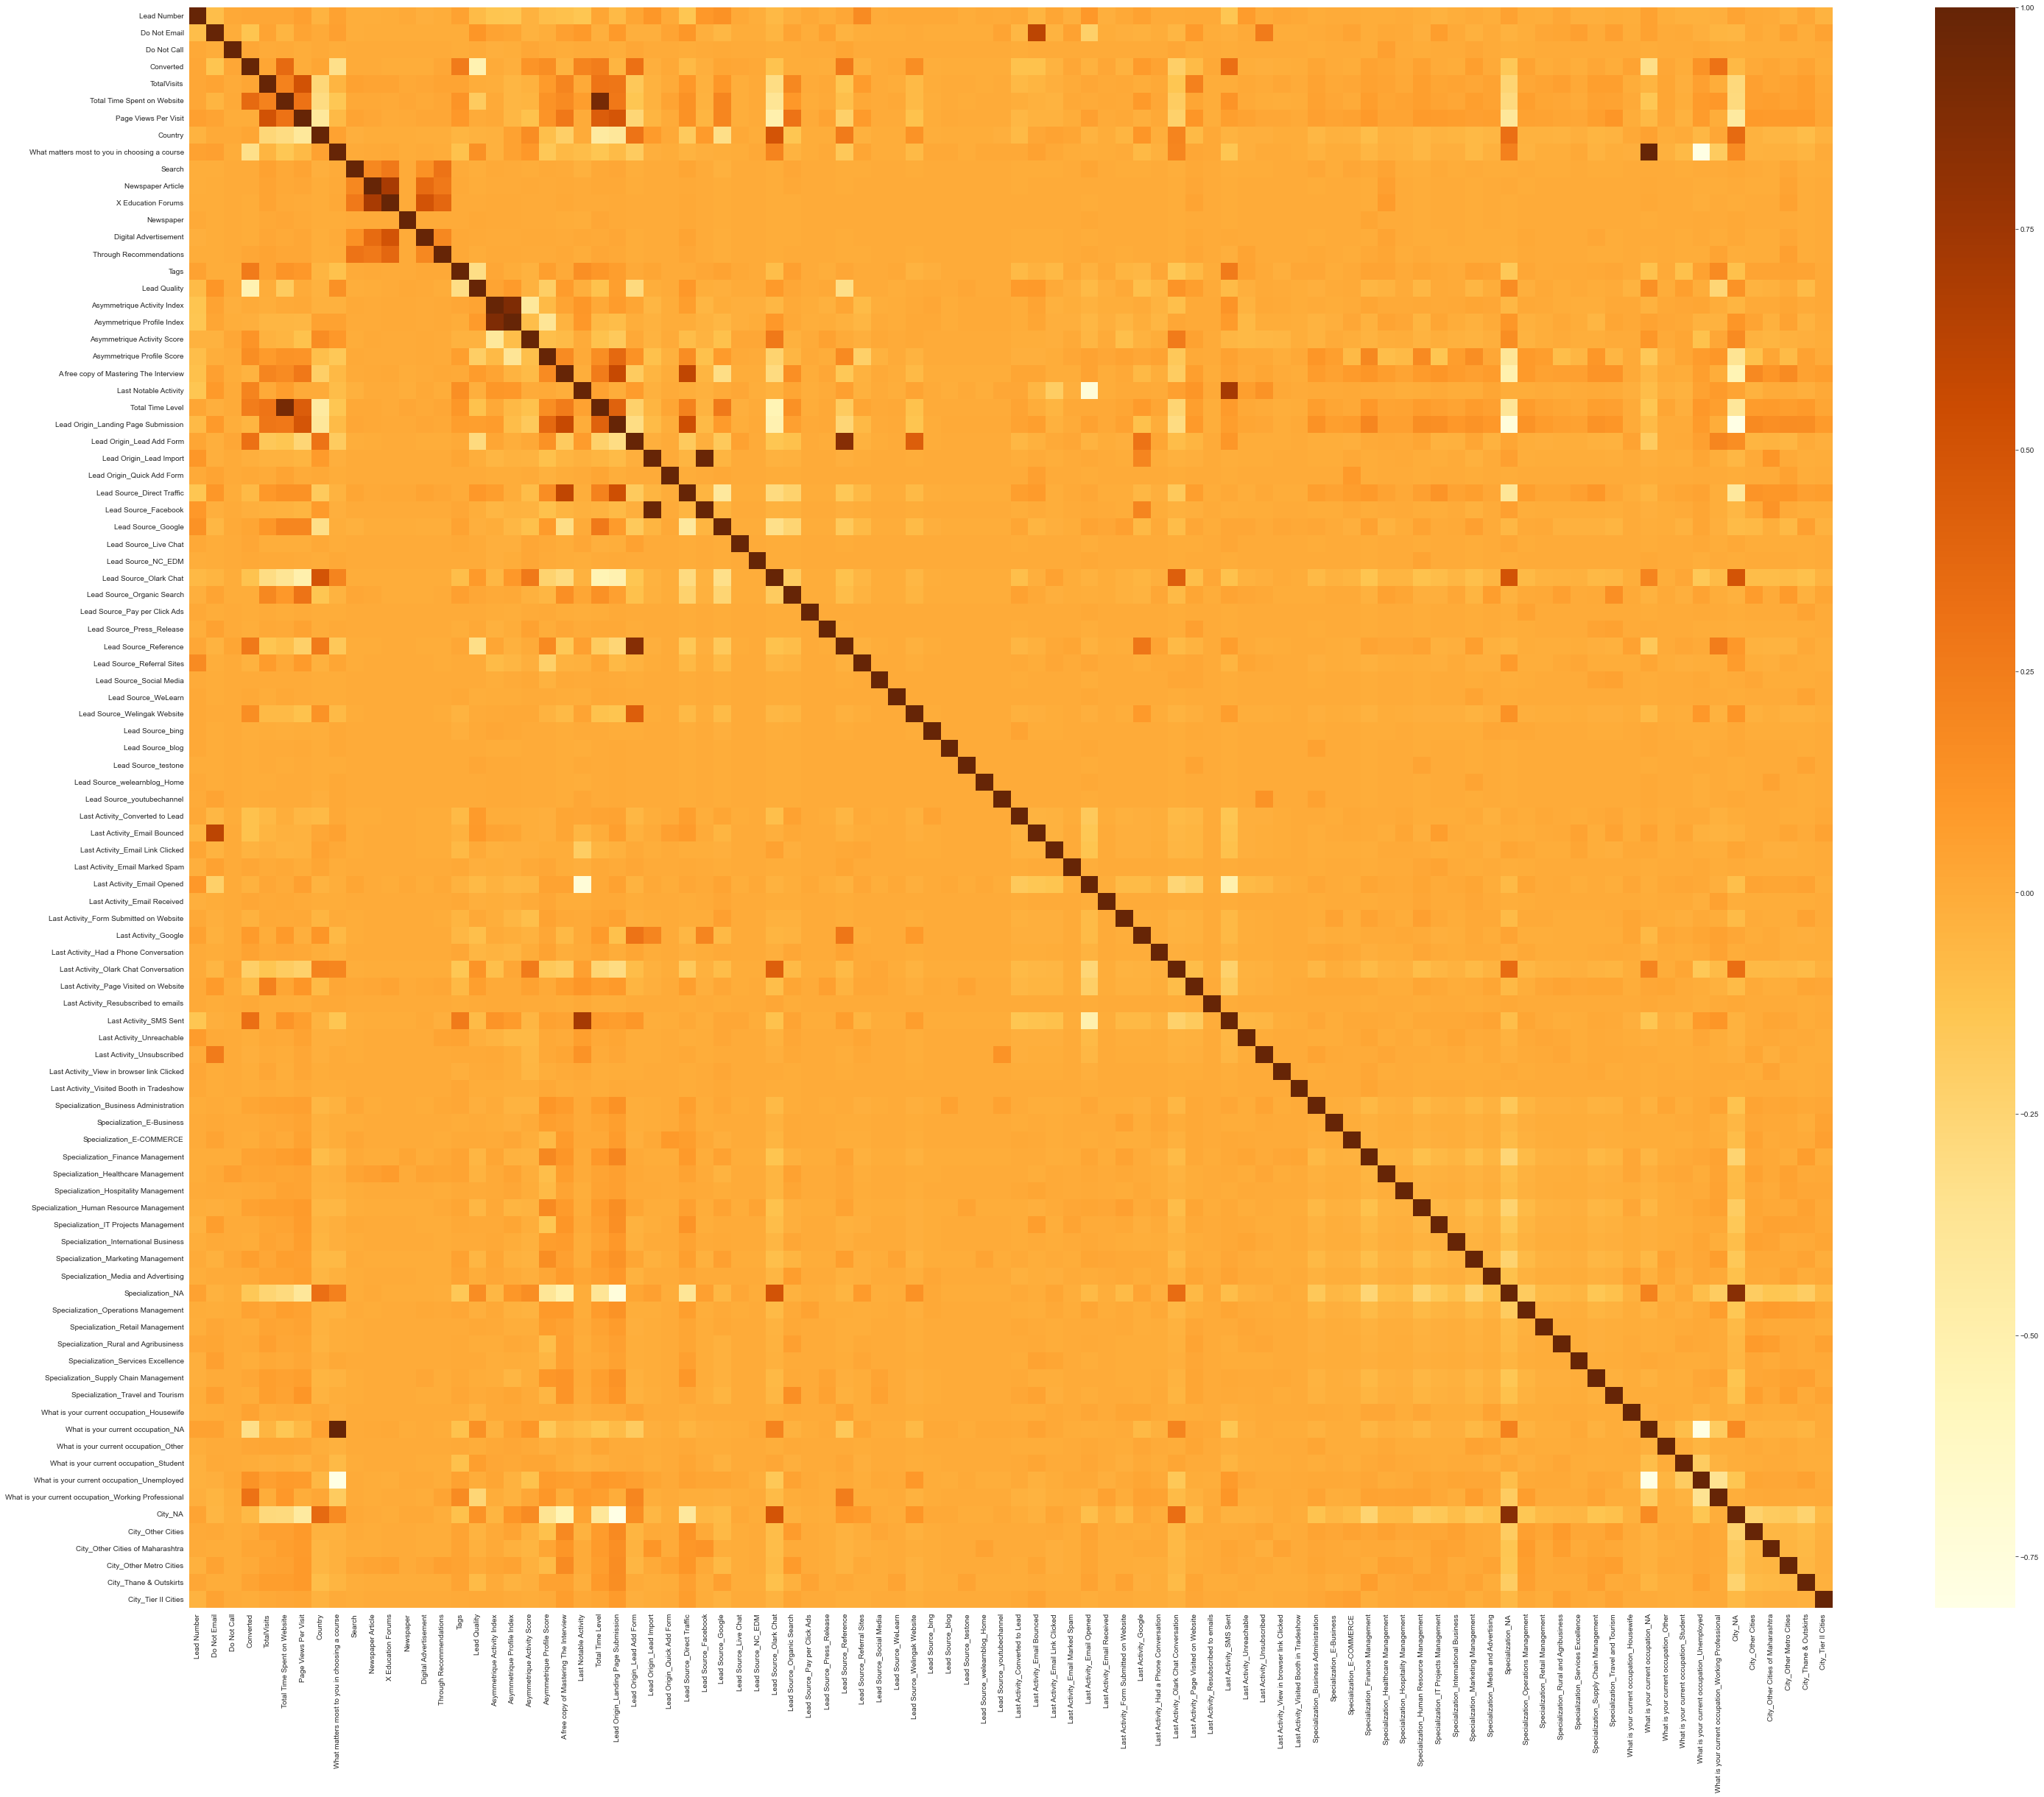

In [48]:
# Let's see the correlation matrix 
plt.figure(figsize = (50,40))        # Size of the figure
sns.heatmap(leads.corr(),cmap="YlOrBr")
plt.show()

#### Observation - 

Following group of columns are positively highly correlated with each other:
1. Search
2. Newspaper Article
3. X Education
4. Digital Advertisement
5. Through Recomendations <br>

Another set of columns are also positively highly correlated with each other: <br>
1. TotalVisits
2. Total Time Spent on Website
3. Page Views Per Visit <br>

There is a strong positive correlation between Asymmetrique Activity Index and Asymmetrique Profile Index.

### Data Preparation for Modeling

#### Train Test split

In [49]:
# Create X and y
y = leads["Converted"]
X = leads.drop("Converted",axis=1)

In [50]:
# Quick review of X and y
X.shape, y.shape

((9240, 94), (9240,))

In [51]:
# Split into trian and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [52]:
# Check shape of train and test
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6468, 94), (2772, 94), (6468,), (2772,))

#### Feature Scaling

In [53]:
# Determine features to scale
col2scale = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit','Asymmetrique Activity Score','Asymmetrique Profile Score']

In [54]:
# Scale X_train
scaler = StandardScaler()
X_train[col2scale] = scaler.fit_transform(X_train[col2scale])
X_train[col2scale].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
1871,-0.656434,-0.885371,-1.085519,0.803541,-0.887613
6795,0.100767,0.005716,-0.470569,-0.165382,-0.144912
3516,0.290067,-0.691418,0.070401,-0.165382,-0.144912
8105,0.290067,1.365219,1.226321,-0.165382,-0.887613
3934,-0.656434,-0.885371,-1.085519,-0.165382,-0.144912


In [55]:
# Scale X_test
X_test[col2scale] = scaler.fit_transform(X_test[col2scale])
X_test[col2scale].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
4269,1.320947,0.933036,2.669778,-0.151002,-0.125990
2376,-0.961886,-0.900812,-1.130671,0.813460,0.617083
7766,0.464884,-0.793792,1.244609,1.777921,-0.869063
9199,-0.961886,-0.900812,-1.130671,2.742382,-0.125990
4359,-0.961886,-0.900812,-1.130671,-0.151002,-0.125990


### Model Building

#### Create a function for model building

In [56]:
# This functions return the model statistics and VIF for the independent variables.
def createmodel(df):

    # Assign X_train
    X_train = df
    
    # Add constant
    X_train_sm = sm.add_constant(X_train)

    # Create object
    logm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())

    # Fit model
    res = logm.fit()

    # Summary
    print(res.summary())
    print(" "*80)
    
    # VIF calculation
    vif = pd.DataFrame()
    vif["Feature"] = X_train.columns
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif["VIF"] = round(vif["VIF"],2)
    print(""*80)
    print(" "*10,"VIF Details"," "*10)
    print("="*80)
    print(vif)
    return X_train_sm,res

In [57]:
# All colummns
initlist = list(X_train.select_dtypes(exclude="object").columns)

#### Initial Model

In [58]:
# Logistic regression model

selected_features = initlist

X_train_sm,res = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6375
Model Family:                Binomial   Df Model:                           92
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1991.5
Date:                Tue, 07 Dec 2021   Deviance:                       3982.9
Time:                        20:27:29   Pearson chi2:                 6.79e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------


           VIF Details           
                                                 Feature     VIF
0                                            Lead Number  710.45
1                                           Do Not Email    2.23
2                                            Do Not Call    1.01
3                                            TotalVisits    1.40
4                            Total Time Spent on Website   10.18
5                                   Page Views Per Visit    2.07
6                                                Country   21.39
7          What matters most to you in choosing a course  137.52
8                                                 Search    1.20
9                                      Newspaper Article    2.02
10                                    X Education Forums    2.77
11                                             Newspaper    1.01
12                                 Digital Advertisement    1.52
13                               Through Recommendation

#### Observations
1. There a features that are not significant.
2. We will use RFE to determine top 20 features

#### Use RFE for feature selection

In [60]:
# Instantiate object
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(X_train[selected_features], y_train)

In [61]:
# Check features selected by RFE
list(zip(X_train[selected_features].columns,rfe.support_,rfe.ranking_))

[('Lead Number', True, 1),
 ('Do Not Email', True, 1),
 ('Do Not Call', False, 25),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Country', True, 1),
 ('What matters most to you in choosing a course', True, 1),
 ('Search', False, 31),
 ('Newspaper Article', False, 45),
 ('X Education Forums', False, 37),
 ('Newspaper', False, 39),
 ('Digital Advertisement', False, 27),
 ('Through Recommendations', False, 21),
 ('Tags', True, 1),
 ('Lead Quality', True, 1),
 ('Asymmetrique Activity Index', True, 1),
 ('Asymmetrique Profile Index', True, 1),
 ('Asymmetrique Activity Score', True, 1),
 ('Asymmetrique Profile Score', True, 1),
 ('A free copy of Mastering The Interview', True, 1),
 ('Last Notable Activity', True, 1),
 ('Total Time Level', True, 1),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 8),
 ('Lead Origin_Quick Add Form', False, 33),
 ('Lead

In [62]:
# List of columns selected by RFE
initrfecols = list(X_train[selected_features].columns[rfe.support_])
initrfecols

['Lead Number',
 'Do Not Email',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Country',
 'What matters most to you in choosing a course',
 'Tags',
 'Lead Quality',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'A free copy of Mastering The Interview',
 'Last Notable Activity',
 'Total Time Level',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Direct Traffic',
 'Lead Source_Google',
 'Lead Source_Olark Chat',
 'Lead Source_Organic Search',
 'Lead Source_Reference',
 'Lead Source_Referral Sites',
 'Lead Source_Welingak Website',
 'Last Activity_Converted to Lead',
 'Last Activity_Email Bounced',
 'Last Activity_Email Link Clicked',
 'Last Activity_Email Opened',
 'Last Activity_Form Submitted on Website',
 'Last Activity_Google',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_Page Visited on Website',
 'Last Activity_SMS Sent',
 '

In [63]:
len(initrfecols)

46

#### Model-1 Using statsmodel for rfe columns

In [64]:
# Building model with features given by RFE
selected_features = [ 'Total Time Spent on Website',
 'Country',
 'What matters most to you in choosing a course',
 'Tags',
 'Lead Quality',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Last Notable Activity',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'Specialization_NA',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional',
 'City_NA']

X_train_sm,res1 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6448
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2136.7
Date:                Tue, 07 Dec 2021   Deviance:                       4273.3
Time:                        20:34:50   Pearson chi2:                 6.75e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Model-2

In [65]:
# Remove 'What matters most to you in choosing a course'
selected_features = [ 'Total Time Spent on Website',
 'Country',
 'Tags',
 'Lead Quality',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Last Notable Activity',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'Specialization_NA',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional',
 'City_NA']

X_train_sm,res2 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6449
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2140.0
Date:                Tue, 07 Dec 2021   Deviance:                       4280.0
Time:                        20:35:00   Pearson chi2:                 6.77e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Model-3

In [66]:
# Remove Asymmetrique Activity Index
selected_features = [ 'Total Time Spent on Website',
 'Country',
 'Tags',
 'Lead Quality',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Last Notable Activity',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'Specialization_NA',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional',
 'City_NA']

X_train_sm,res3 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6450
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2159.5
Date:                Tue, 07 Dec 2021   Deviance:                       4319.0
Time:                        20:35:07   Pearson chi2:                 6.75e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Model-4

In [67]:
# Remove   'Last Notable Activity'
selected_features = [ 'Total Time Spent on Website',
 'Country',
 'Tags',
 'Lead Quality',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'Specialization_NA',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional',
 'City_NA']

X_train_sm,res4 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2159.5
Date:                Tue, 07 Dec 2021   Deviance:                       4319.1
Time:                        20:35:14   Pearson chi2:                 6.75e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Model-5

In [68]:
# Remove  'Country'
selected_features = [ 'Total Time Spent on Website',
 'Tags',
 'Lead Quality',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'Specialization_NA',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional',
 'City_NA']


X_train_sm,res5 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2159.5
Date:                Tue, 07 Dec 2021   Deviance:                       4319.1
Time:                        20:35:19   Pearson chi2:                 6.75e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Model-6

In [69]:
# Remove  'City_NA'
selected_features = [ 'Total Time Spent on Website',
 'Tags',
 'Lead Quality',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional']


X_train_sm,res6 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2161.6
Date:                Tue, 07 Dec 2021   Deviance:                       4323.3
Time:                        20:35:23   Pearson chi2:                 6.77e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [63]:
# Remove  'City_NA'
selected_features = [ 'Total Time Spent on Website',
 'Tags',
 'Lead Quality',
 'Asymmetrique Profile Index',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score',
 'Lead Origin_Landing Page Submission',
 'Lead Origin_Lead Add Form',
 'Lead Source_Olark Chat',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_SMS Sent',
 'What is your current occupation_NA',
 'What is your current occupation_Working Professional']


X_train_sm,res6 = createmodel(X_train[selected_features])

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2161.6
Date:                Mon, 18 Nov 2019   Deviance:                       4323.3
Time:                        07:47:01   Pearson chi2:                 6.77e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                          

#### Predicting based on latest model

In [70]:
# Predicting based on latest model
y_train_pred = res6.predict(X_train_sm)
y_train_pred[:10]

1871    0.119139
6795    0.156402
3516    0.259101
8105    0.872717
3934    0.212769
4844    0.989880
3297    0.030686
8071    0.996280
987     0.314992
7423    0.963810
dtype: float64

In [71]:
# Creating dataframe with prediction probability
lead_train_pred = pd.DataFrame({"Lead Number":X_train["Lead Number"],"Converted":y_train.values,"Convert_prob":y_train_pred})
lead_train_pred.head()

,Lead Number,Converted,Convert_prob
1871,641410,0,0.119139
6795,597687,0,0.156402
3516,626825,0,0.259101
8105,587928,0,0.872717
3934,622366,0,0.212769


In [72]:
# Creating a "Convert_Pred" with cutoff of 0.5
lead_train_pred['Convert_Pred'] = lead_train_pred['Convert_prob'].apply(lambda x:1 if x>0.5 else 0)

lead_train_pred.head()

,Lead Number,Converted,Convert_prob,Convert_Pred
1871,641410,0,0.119139,0
6795,597687,0,0.156402,0
3516,626825,0,0.259101,0
8105,587928,0,0.872717,1
3934,622366,0,0.212769,0


In [73]:
# Confusion matrix 
confusion = metrics.confusion_matrix(lead_train_pred['Converted'], lead_train_pred['Convert_Pred'])
print(confusion)

[[3630  372]
 [ 556 1910]]


In [74]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(lead_train_pred['Converted'], lead_train_pred['Convert_Pred']))

0.8565244279529994


#### Create confusion metrics

In [75]:
# Create function that will return metrics and score
def confscores(conf):
    TP = conf[1,1] # true positive 
    TN = conf[0,0] # true negatives
    FP = conf[0,1] # false positives
    FN = conf[1,0] # false negatives
    
    sensitivity = TP/float(TP+FN)
    specificity = TN/float(TN+FP)
    precision = TP/float(TP+FP)
    accuracy = float(TP+TN)/float(TP+FP+TN+FN)
    
    print("Accuracy: ", round(accuracy,4))
    print("Sensitivity: ", round(sensitivity,4))
    print("Specificity: ", round(specificity,4))
    print("Precision: ", round(precision,4))

In [76]:
# Check accuracy, sensitivity, specificity and precision for model
confscores(confusion)

Accuracy:  0.8565
Sensitivity:  0.7745
Specificity:  0.907
Precision:  0.837


#### We have a decent metrics with 0.5 cutoff. We will further analyze to see if we can get better cutoff

#### Plot ROC Curve

In [77]:
# Function for ROC
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC plot')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [78]:
# Calcualte FPR, TPR
fpr, tpr, thresholds = metrics.roc_curve(lead_train_pred['Converted'], lead_train_pred['Convert_prob'], drop_intermediate = False )

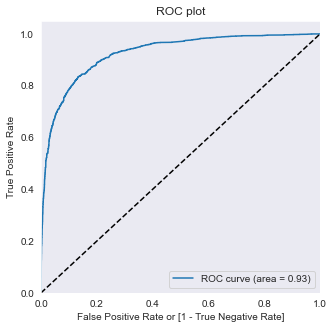

In [79]:
# Draw ROC Curve
draw_roc(lead_train_pred['Converted'], lead_train_pred['Convert_prob'])

#### Find Optimal cutoff value

In [80]:
# Plot cutoff values
cutoff_values = [0.1,0.2,0.3,0.4,0.5,0.6]

for i in cutoff_values:
    lead_train_pred[i] = lead_train_pred['Convert_prob'].apply(lambda x:1 if x>i else 0)
    
lead_train_pred.head()

,Lead Number,Converted,Convert_prob,Convert_Pred,0.1,0.2,0.3,0.4,0.5,0.6
1871,641410,0,0.119139,0,1,0,0,0,0,0
6795,597687,0,0.156402,0,1,0,0,0,0,0
3516,626825,0,0.259101,0,1,1,0,0,0,0
8105,587928,0,0.872717,1,1,1,1,1,1,1
3934,622366,0,0.212769,0,1,1,0,0,0,0


In [81]:
# Plot accuracy, sensitivity, specificity

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.1,0.2,0.3,0.4,0.5,0.6]
for i in num:
    cm1 = metrics.confusion_matrix(lead_train_pred['Converted'], lead_train_pred[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.1   0.1  0.727737  0.966342  0.580710
0.2   0.2  0.811843  0.922952  0.743378
0.3   0.3  0.838899  0.871857  0.818591
0.4   0.4  0.853741  0.825223  0.871314
0.5   0.5  0.856524  0.774534  0.907046
0.6   0.6  0.850804  0.708435  0.938531


#### Plot accuracy sensitivity and specificity

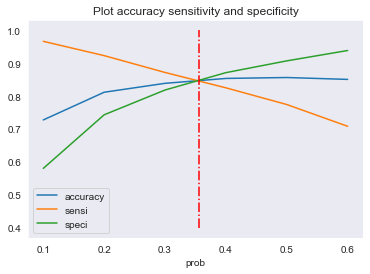

In [82]:
#Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.355, ymax=1, ymin=0.4, colors="r", linestyles="-.")
plt.title("Plot accuracy sensitivity and specificity")
plt.show()

#### Confusion metrics and scores

In [83]:
# Function to calcualte confusion metrics and scores
def calctrainseult(cutoff):
    optimal_cutoff = cutoff
    print("Mertic for cutoff: ",optimal_cutoff)
    print("="*50)
    # Building prediction with optimal cutoff value
    lead_train_pred["Convert_Pred_optimal"] = lead_train_pred['Convert_prob'].apply(lambda x:1 if x>optimal_cutoff else 0)

    # Confusion metrix 
    confusion = metrics.confusion_matrix(lead_train_pred['Converted'], lead_train_pred['Convert_Pred_optimal'])
    print("Confusion Metrics")
    print(confusion)
    print("="*50)

    # Check accuracy, sensitivity, specificity and precision for model
    print("Score")
    confscores(confusion)

In [84]:
# Calculate train result for cutoff 0.355
calctrainseult(0.355)

Mertic for cutoff:  0.355
Confusion Metrics
[[3419  583]
 [ 385 2081]]
Score
Accuracy:  0.8503
Sensitivity:  0.8439
Specificity:  0.8543
Precision:  0.7812


#### Precision - Recall plot

In [85]:
# Calcualte precision and recall
p, r, thresholds = precision_recall_curve(lead_train_pred['Converted'], lead_train_pred['Convert_prob'])

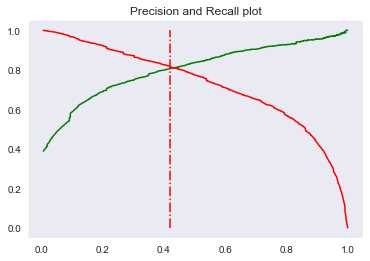

In [86]:
# Plot precisio and recall
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.vlines(x=0.42, ymax=1, ymin=0.0, colors="r", linestyles="-.")
plt.title("Precision and Recall plot")
plt.show()

In [87]:
# Calculate train result for cutoff 0.42
calctrainseult(0.42)

Mertic for cutoff:  0.42
Confusion Metrics
[[3515  487]
 [ 448 2018]]
Score
Accuracy:  0.8554
Sensitivity:  0.8183
Specificity:  0.8783
Precision:  0.8056


#### cutoff of 0.43 is the optimal value.

In [88]:
# Set optimal cutoff
optimal_cutoff = 0.42
calctrainseult(optimal_cutoff)

Mertic for cutoff:  0.42
Confusion Metrics
[[3515  487]
 [ 448 2018]]
Score
Accuracy:  0.8554
Sensitivity:  0.8183
Specificity:  0.8783
Precision:  0.8056


### Making prediction on test set

In [89]:
#  Create a dataframe
lead_test_pred = pd.DataFrame({"Lead Number":X_test["Lead Number"]})
lead_test_pred.head()

,Lead Number
4269,619003
2376,636884
7766,590281
9199,579892
4359,617929


In [90]:
# Xtest with selected features
X_test_final = X_test[selected_features]

# Add constant
X_test_sm = sm.add_constant(X_test_final)

In [91]:
# Make prediction on test set
y_test_pred = res6.predict(X_test_sm)
y_test_pred[:10]

4269    0.572262
2376    0.988575
7766    0.861485
9199    0.080951
4359    0.930710
9186    0.962313
1631    0.898163
8963    0.335530
8007    0.042091
5324    0.919021
dtype: float64

In [92]:
# Add converted, converted_test_probability column
lead_test_pred["Converted"] = y_test.values
lead_test_pred["Convert_prob"] = y_test_pred
lead_test_pred.head()

,Lead Number,Converted,Convert_prob
4269,619003,1,0.572262
2376,636884,1,0.988575
7766,590281,1,0.861485
9199,579892,0,0.080951
4359,617929,1,0.930710


In [93]:
# Final prediction on test
lead_test_pred['final_predicted'] = lead_test_pred['Convert_prob'].apply(lambda x:1 if x>optimal_cutoff else 0)
lead_test_pred.head()

,Lead Number,Converted,Convert_prob,final_predicted
4269,619003,1,0.572262,1
2376,636884,1,0.988575,1
7766,590281,1,0.861485,1
9199,579892,0,0.080951,0
4359,617929,1,0.930710,1


In [94]:
# Confusion Metrics
confusion2 = metrics.confusion_matrix(lead_test_pred['Converted'], lead_test_pred['final_predicted'])
confusion2

array([[1508,  169],
       [ 215,  880]])

In [95]:
# Check accuracy, sensitivity, specificity and precision for model
confscores(confusion2)

Accuracy:  0.8615
Sensitivity:  0.8037
Specificity:  0.8992
Precision:  0.8389


### Find Principal Components using PCA

In [96]:
# Drop Prospect ID and Lead Number
X_train1 = X_train.drop(["Prospect ID","Lead Number"],axis=1)

In [97]:
# Create pca object
pca = PCA(random_state=100)
pca.fit(X_train1)

PCA(random_state=100)

In [98]:
# Check variance
pca.explained_variance_ratio_

array([4.74384322e-01, 2.32573825e-01, 1.21667691e-01, 3.54107756e-02,
       2.87754508e-02, 1.71594042e-02, 1.56225315e-02, 1.28790944e-02,
       1.22135640e-02, 9.03657064e-03, 6.51366631e-03, 5.48445533e-03,
       2.94327286e-03, 1.90022039e-03, 1.70827061e-03, 1.64664271e-03,
       1.49040101e-03, 1.28373416e-03, 1.23061197e-03, 1.15206851e-03,
       1.11429151e-03, 1.03446616e-03, 9.16636878e-04, 8.83048341e-04,
       8.27735168e-04, 8.02556451e-04, 7.40384411e-04, 6.41847835e-04,
       5.98259610e-04, 5.71999795e-04, 5.60194800e-04, 4.94058776e-04,
       4.43127409e-04, 4.31119213e-04, 3.78657486e-04, 3.42168899e-04,
       3.33258616e-04, 3.08277389e-04, 3.04977114e-04, 2.78268868e-04,
       2.51356717e-04, 2.34489774e-04, 2.28045213e-04, 2.20757849e-04,
       2.00976128e-04, 1.76184422e-04, 1.68203116e-04, 1.63954972e-04,
       1.58524460e-04, 1.39539348e-04, 1.33025141e-04, 1.10956486e-04,
       9.34583192e-05, 9.12466830e-05, 8.56532373e-05, 7.21381611e-05,
      

In [99]:
# Cummulative variance
probsum = np.cumsum(pca.explained_variance_ratio_)
probsum

array([0.47438432, 0.70695815, 0.82862584, 0.86403661, 0.89281206,
       0.90997147, 0.925594  , 0.93847309, 0.95068666, 0.95972323,
       0.96623689, 0.97172135, 0.97466462, 0.97656484, 0.97827311,
       0.97991976, 0.98141016, 0.98269389, 0.9839245 , 0.98507657,
       0.98619086, 0.98722533, 0.98814197, 0.98902501, 0.98985275,
       0.99065531, 0.99139569, 0.99203754, 0.9926358 , 0.9932078 ,
       0.99376799, 0.99426205, 0.99470518, 0.9951363 , 0.99551496,
       0.99585712, 0.99619038, 0.99649866, 0.99680364, 0.99708191,
       0.99733326, 0.99756775, 0.9977958 , 0.99801656, 0.99821753,
       0.99839372, 0.99856192, 0.99872587, 0.9988844 , 0.99902394,
       0.99915696, 0.99926792, 0.99936138, 0.99945262, 0.99953828,
       0.99961042, 0.99967529, 0.99973496, 0.9997784 , 0.99981317,
       0.99983766, 0.99986018, 0.99988051, 0.9998998 , 0.99991548,
       0.99992599, 0.99993599, 0.99994397, 0.99995039, 0.99995524,
       0.99995941, 0.99996315, 0.99996688, 0.99997044, 0.99997

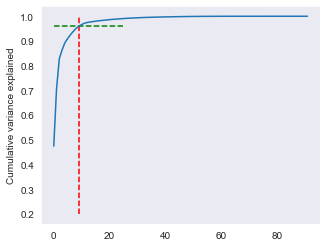

In [100]:
# plot cummulative variance
fig = plt.figure(figsize=[5,4])
plt.vlines(x=9, ymax=1, ymin=0.2, colors="r", linestyles="--")
plt.hlines(y=0.9623, xmax=25, xmin=0, colors="g", linestyles="--")
plt.plot(probsum)
plt.ylabel("Cumulative variance explained")
plt.show()

In [101]:
# Perform PCA usign 10 components
pcafinal = IncrementalPCA(n_components=10)

In [102]:
# Fit PCA
df_train_pca = pcafinal.fit_transform(X_train1)
df_train_pca

array([[ 0.94899304,  5.08888072, -4.13763453, ...,  1.6597912 ,
         0.54250243,  0.27669048],
       [-1.33250323, -2.51829992, -3.38541085, ...,  0.65242906,
         0.37110362,  0.71915172],
       [ 1.0849361 ,  4.80077818, -3.91740096, ...,  0.38014121,
         0.7687959 , -0.1686784 ],
       ...,
       [-1.97333334,  4.92871585, -3.82098823, ...,  1.16804639,
         0.88059168, -0.19847689],
       [-8.76909381, -2.81199608,  1.48261896, ..., -0.3772159 ,
         0.91777912,  0.01582742],
       [-1.57015913,  5.07789075,  0.24692927, ..., -0.91817965,
        -0.9894541 ,  0.09112783]])

<AxesSubplot:>

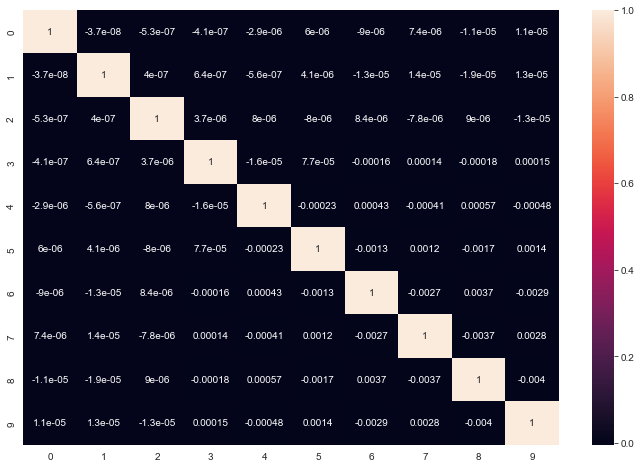

In [103]:
# Correlation Matrix
corrmat = np.corrcoef(df_train_pca.transpose())
plt.figure(figsize=[12,8])
sns.heatmap(corrmat, annot=True)

In [104]:
# Checking shape of PCA dataframe
X_train.shape, X_test.shape

((6468, 94), (2772, 94))

In [105]:
# Drop Prospect ID and Lead Number
X_test1 = X_test.drop(["Prospect ID","Lead Number"],axis=1)

In [106]:
# Transform Test dataset
df_test_pca = pcafinal.transform(X_test1)
df_test_pca.shape

(2772, 10)

### Logictic Regression on PCA

In [107]:
# Instantiate object
lr = LogisticRegression()

# Fit model
lrm = lr.fit(df_train_pca,y_train)

In [108]:
# Predict on test set
y_pred_prob = lrm.predict_proba(df_test_pca)

In [109]:
# Probability for conversion
lead_test_pred['pca_test_prob1'] = y_pred_prob[:,1]

In [110]:
# Check ROC score
"{:2.2}".format(metrics.roc_auc_score(y_test, lead_test_pred['pca_test_prob1']))

'0.9'

In [111]:
# Final prediction on test
lead_test_pred['pca_predicted'] = lead_test_pred['pca_test_prob1'].apply(lambda x:1 if x>optimal_cutoff else 0)
lead_test_pred.head()

,Lead Number,Converted,Convert_prob,final_predicted,pca_test_prob1,pca_predicted
4269,619003,1,0.572262,1,0.265145,0
2376,636884,1,0.988575,1,0.949916,1
7766,590281,1,0.861485,1,0.815924,1
9199,579892,0,0.080951,0,0.218581,0
4359,617929,1,0.930710,1,0.825559,1


In [112]:
# Confusion Metrics
confusion3 = metrics.confusion_matrix(lead_test_pred['Converted'], lead_test_pred['pca_predicted'])
confusion3

array([[1460,  217],
       [ 257,  838]])

In [113]:
# Confusion metrics for PCA
print("PCA - Confusion metric")
print(confusion3)

PCA - Confusion metric
[[1460  217]
 [ 257  838]]


In [114]:
# Check accuracy, sensitivity, specificity and precision for model
print("PCA - Scores")
confscores(confusion3)

PCA - Scores
Accuracy:  0.829
Sensitivity:  0.7653
Specificity:  0.8706
Precision:  0.7943


### Model Conclusion
1. We are getting better results without using PCA.
2. We will use model6 for prediction and conclusion

#### Merging train and test prediction

In [115]:
# Merging train and test prediction
# all_pred = pd.concat([train_pred,test_pred])
all_pred = pd.concat([lead_train_pred[["Lead Number","Convert_prob"]],lead_test_pred[["Lead Number","Convert_prob"]]])
all_pred.shape

(9240, 2)

In [116]:
# Creating a copy of leads dataframe
leads_orig2 =  leads_orig.copy()

#### Merging predictions to original dataframe

In [117]:
# Merging predictions with original dataframe
leads_orig2 = pd.merge(leads_orig2,all_pred,on="Lead Number", how="left")
leads_orig2.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Convert_prob
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified,0.732976
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened,0.386793


#### Creating Lead Score column

In [118]:
# Create a Lead Score column from probability
leads_orig2["Lead Score"] = leads_orig2["Convert_prob"].apply(lambda c:round(c*100))
leads_orig2.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Convert_prob,Lead Score
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified,0.732976,73
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened,0.386793,39


#### Creating a dataframe with cutoff and conversion%

In [119]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
# df_conversion = pd.DataFrame( columns = ['Lead_Score_Cutoff','Conversion_Ratio'])

conv_list = []

cutoffs = list(range(5,100,5))

for cutoff in cutoffs:

    total_converted = leads_orig2[leads_orig2["Lead Score"]>=cutoff]["Converted"].sum()
    all_leads = len(leads_orig2[leads_orig2["Lead Score"]>=cutoff].index)
    conv_ratio = round(100*(total_converted/all_leads),2)
    
    conv_list.append([cutoff,conv_ratio])
    

df_conversion = pd.DataFrame(conv_list,columns=['Lead_Score_Cutoff','Conversion_Ratio'])
df_conversion

,Lead_Score_Cutoff,Conversion_Ratio
0,5,48.17
1,10,58.70
2,15,64.79
3,20,69.34
4,25,72.91
5,30,75.16
6,35,77.30
7,40,80.52
8,45,82.17
9,50,84.17


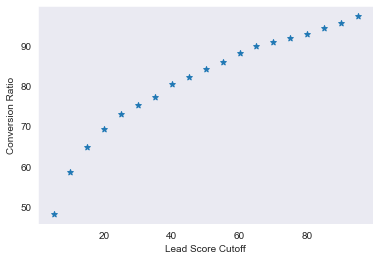

In [120]:
# Plot cutoff vs Conversion Ratio
x=df_conversion['Lead_Score_Cutoff']
y=df_conversion['Conversion_Ratio']
plt.xlabel("Lead Score Cutoff")
plt.ylabel("Conversion Ratio")
plt.scatter(x,y,marker="*")

### Conclusion
    1.Top three features that contribute to decision
        * Lead Origin
        * What is your current occupation
        * Last Activity
    2.Top three categories that contribute to decision
        * Lead Origin ==> Lead Add Form
        * What is your current occupation ==> Working Professional 
        * Last Activity ==> SMS Sent 